# Triangulate data from multiple Sleap networks

(latest version on Github at https://github.com/tytell/tytell-lab.git)
This file from commit $Id$

Requires `sleap` (https://sleap.ai/index.html) and `aniposelib` (version 0.6.1 or higher). Follow the directions to set up Sleap. Then  install `aniposelib` in the same python environment as Sleap: 
> % conda activate sleap

> % python -m pip install aniposelib

# Load in the Sleap data files

In [5]:
from sleap.io.dataset import Labels
import os
import re
import aniposelib

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import triangulate_sleap

Load the calibration we did above. Make sure the file name is correct!

In [4]:
camgroup = aniposelib.cameras.CameraGroup.load('calibration.toml')

Fill in the names of your cameras and the names of the Sleap `.slp` data files. You should have the same number of Sleap files as you do cameras. But if you trained the same network for multiple views, just repeat the name of the `.slp` file.

Note that the videos need to have matching names across the cameras. So you should have something like:
* test1_camA.mp4, test1_camB.mp4, test1_camC.mp4

or

* camA_test1.mp4, camB_test1.mp4, camC_test1.mp4

or something like that.

In [15]:
camnames = ["camA", "camB", "camC"]

sleapfiles = ['/Users/etytel01/Documents/2024/StephenAcceleration/sleap/Pumpkinseed/PumpkinseedLateral.slp',
              '/Users/etytel01/Documents/2024/StephenAcceleration/sleap/Pumpkinseed/PumpkinseedLateral.slp',
              '/Users/etytel01/Documents/2024/StephenAcceleration/sleap/Pumpkinseed/PumpkinseedVentral.slp']

This will load in the Sleap points and the calibration. You can restrict to a certain number of videos using the `match_video` option, which uses usual file matching syntax (`*` matches anything, so `'*11.15.23*'` will match any videos that have 11.15.23 in the name)

In [69]:
camgroup, ptsall = triangulate_sleap.load_sleap_points(sleapfiles, 'calibration.toml', match_video='*11.15.23*')

Found 42675 frames across 4 matched videos


/Users/etytel01/Documents/2023/tytell-lab-code/triangulate_sleap.py:178: UserWarning: Video D:/Stephen Acceleration/sleap/Pumpkinseed/11.15.23/11.15.23Videos/.98Vcon-11.15.23_Trial20_0RampcamC.mp4 in Sleap file multiple times
  next
/Users/etytel01/Documents/2023/tytell-lab-code/triangulate_sleap.py:178: UserWarning: Video D:/Stephen Acceleration/sleap/Pumpkinseed/11.15.23/11.15.23Videos/1V-11.15.23_Trial9_1.4RampcamC.mp4 in Sleap file multiple times
  next


Then this triangulates the points and computes the reprojections.

In [83]:
ptsall3d, picked, picked2d, err = triangulate_sleap.triangulate_points(camgroup, ptsall, use_possible=True)

[autoreload of triangulate_sleap failed: Traceback (most recent call last):
  File "/Users/etytel01/anaconda3/envs/sleap/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/Users/etytel01/anaconda3/envs/sleap/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/Users/etytel01/anaconda3/envs/sleap/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 846, in exec_module
  File "<frozen importlib._bootstrap_external>", line 983, in get_code
  File "<frozen importlib._bootstrap_external>", line 913, in source_to_code
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/Users/etytel01/Documents/2023/tytell-lab-code/triangulate_sleap.py", line 104
    q 

## Triangulating points


100%|█████████████████████████| 42675/42675 [00:11<00:00, 3846.20it/s]


Finally, you can check the reprojections by plotting them. This will show the camera views, with red points representing the original tracked points, yellow crosses for the reprojected points, and yellow lines connecting the same point.

frame == 113 and video == "1V-11.15.23_Trial9_1.4RampCAMERA.mp4"


/var/folders/rs/r2xck00j2td2g2w0g6s_t2lx370bnk/T/ipykernel_30156/2466124920.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


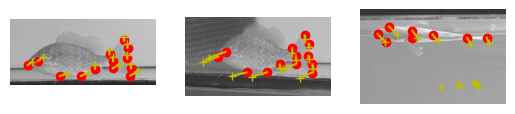

In [106]:
fig = triangulate_sleap.plot_reprojected_points(ptsall3d, 20000, 
                                          videopath='/Users/etytel01/Documents/2024/StephenAcceleration/sleap/Pumpkinseed/11.15.23/11.15.23Videos',
                                          zoom=True)
fig.show()


Load in the Sleap data files

In [7]:
labels = [Labels.load_file(fn) for fn in sleapfiles]

node_count = len(labels[0].skeletons[0].nodes)
node_names = [node.name for node in labels[0].skeletons[0].nodes]

videos = [[v1.backend.filename for v1 in l1.videos if re.search(c1, v1.backend.filename) is not None] for l1, c1 in zip(labels, camnames)]

In [13]:
','.join([3, 3, 2])

TypeError: sequence item 0: expected str instance, int found

In [12]:
import fnmatch

fnmatch.filter(videos[0], '*11.15.23*')

['D:/Stephen Acceleration/sleap/Pumpkinseed/11.15.23/11.15.23Videos/.2V-11.15.23_Trial1_.2RampcamA.mp4',
 'D:/Stephen Acceleration/sleap/Pumpkinseed/11.15.23/11.15.23Videos/1V-11.15.23_Trial9_1.4RampcamA.mp4',
 'D:/Stephen Acceleration/sleap/Pumpkinseed/11.15.23/11.15.23Videos/.4V-11.15.23_Trial12_3.5RampcamA.mp4',
 'D:/Stephen Acceleration/sleap/Pumpkinseed/11.15.23/11.15.23Videos/.98Vcon-11.15.23_Trial20_0RampcamA.mp4']

Function to separate the name of a video and the camera names, so that we can match up videos for different cameras.

In [139]:
def separate_video_and_camera(vidname, camnames):
    fn1 = re.sub(r'\\', '/', vidname)
    fn1 = os.path.basename(fn1)

    for cam1 in camnames:
        fn1, nsub = re.subn(cam1, 'CAMERA', fn1)
        if nsub == 1:
            matched_camera = cam1
            break
    else:
        matched_camera = None

    return fn1, matched_camera

Pull out the $x$ and $y$ coordinates from the Sleap data files and match the same point in the same frame across cameras.

In [161]:
nodenames = [n.name for n in labels[0].skeletons[0].nodes]

ptsall = []
for l1, cam1 in zip(labels, camnames):
    pts = []
    for v1 in l1.videos:
        vidname1, camname1 = separate_video_and_camera(v1.backend.filename, camnames)
        if camname1 != cam1:
            continue
        
        frames = l1.get(v1)
        frame_idx = [lf.frame_idx for lf in frames]

        col_ind = pd.MultiIndex.from_product([[camname1], ['x', 'y']],
                                             names = ['camera', 'point'])
        row_ind = pd.MultiIndex.from_product([[vidname1], frame_idx, nodenames], 
                                             names = ['video', 'frame', 'node'])

        pts1 = pd.DataFrame(index = row_ind, columns=col_ind)

        for lf in frames:
            if len(lf.user_instances) == 1:
                inst = lf.user_instances[0]
            elif len(lf.predicted_instances) == 1:
                inst = lf.predicted_instances[0]
            else:
                print("Error!")
                assert(False)
            
            pts1.loc[(vidname1, lf.frame_idx, slice(None)), (camname1, slice(None))] = inst.numpy()

        pts.append(pts1)
    
    ptsall.append(pd.concat(pts, axis=0))

ptsall = pd.concat(ptsall, axis=1)

In [162]:
ptsall.head()

camera                                                          camA  \
point                                                              x   
video                               frame node                         
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout           707.526168   
                                          GillCenterLow       748.02   
                                          PelvFinsCenter  781.178769   
                                          MidPelvAnal     807.950671   
                                          AnalBase        818.053275   

camera                                                                \
point                                                              y   
video                               frame node                         
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout           194.342777   
                                          GillCenterLow       222.92   
                                          PelvFinsCenter  227.122296   
                                          MidPelvAnal     225.924293   
                                          AnalBase        225.924293   

camera                                                           camB  \
point                                                               x   
video                               frame node                          
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout               1252.28   
                                          GillCenterLow        1340.9   
                                          PelvFinsCenter      1398.11   
                                          MidPelvAnal     1435.700043   
                                          AnalBase        1471.253292   

camera                                                                \
point                                                              y   
video                               frame node                         
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout               498.26   
                                          GillCenterLow       491.06   
                                          PelvFinsCenter      491.36   
                                          MidPelvAnal     483.431097   
                                          AnalBase        481.959874   

camera                                                           camC  \
point                                                               x   
video                               frame node                          
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout           1025.193042   
                                          GillCenterLow       1103.15   
                                          PelvFinsCenter   1141.59631   
                                          MidPelvAnal     1122.599477   
                                          AnalBase        1196.597994   

camera                                                                
point                                                              y  
video                               frame node                        
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout            416.56818  
                                          GillCenterLow       404.17  
                                          PelvFinsCenter  400.452633  
                                          MidPelvAnal     404.822813  
                                          AnalBase        395.610202

Reshape the DataFrame into a 3D numpy matrix. Should have shape $C \times N \times 2$, where $C$ is the number of cameras, $N$ is the number of points, and 2 is for $x$ and $y$ coordinates.

In [163]:
ptsmatrix = ptsall.to_numpy().reshape((-1, 3, 2))
ptsmatrix = ptsmatrix.transpose((1,0,2)).astype(np.float64)
print(ptsmatrix.shape)

(3, 2898, 2)


Show the first point in each camera so that we can compare to the DataFrame above. Should have x and y in the columns and cameras in the rows.

In [164]:
ptsmatrix[:,0,:]

array([[ 707.526168,  194.342777],
       [1252.28    ,  498.26    ],
       [1025.193042,  416.56818 ]])

Triangulate the points to 3D. NB - it's important to do the undistortion. Without it, we get *terrible* reprojection errors.

In [165]:
pts3d = camgroup.triangulate(ptsmatrix, progress=True, undistort=True)

100%|███████████████████████████| 2898/2898 [00:00<00:00, 2975.60it/s]


In [166]:
reproj = camgroup.project(pts3d)
reproj = reproj.transpose((1,0,2))
reproj = reproj.reshape((-1, 6))
reproj.shape

(2898, 6)

...and compute the reprojection error.

In [167]:
reproj_err = camgroup.reprojection_error(pts3d, ptsmatrix, mean=False)
errors_norm = np.linalg.norm(reproj_err, axis=2)

In [168]:
errors_norm[:,0:5]

array([[ 1.68047637,  0.14213315,  3.64142629, 18.66773313,  2.21700235],
       [ 5.94005711,  3.65465057,  1.87581386, 13.80525487,  4.39023732],
       [ 4.55285816,  2.93272322,  5.13284135, 38.26594489,  4.33334158]])

Now build up the same DataFrame as the original points so that we can merge them all.

First for the 3D points themselves

In [169]:
col_ind = pd.MultiIndex.from_product([['3D'], ['x', 'y', 'z']],
                                        names = ['camera', 'point'])

pts3d = pd.DataFrame(pts3d, index=ptsall.index, columns=col_ind)

...and then for the reprojection error. The original reprojection error gives us errors in both $x$ and $y$, but we're just interested in the distance, so we use `np.linalg.norm` to get the distance and then merge it into a DataFrame

In [170]:
col_ind = pd.MultiIndex.from_product([camnames, ['reproj_err']],
                                        names = ['camera', 'point'])

errors_norm = pd.DataFrame(errors_norm.T, index=ptsall.index, columns=col_ind)

These are the median reprojection errors. Make sure they're not too big.

In [171]:
errors_norm.groupby(level=2).median()

camera,camA,camB,camC
point,reproj_err,reproj_err,reproj_err
node,,,
AnalBase,1.817333,3.383312,3.655082
GillCenterLow,1.688002,3.654855,4.486997
MidAnalBasePeduncle,2.293947,4.113208,3.605914
MidPelvAnal,1.836503,4.559257,5.333551
Peduncle,1.791392,2.989039,3.751766
PelvFinsCenter,1.859327,3.786786,3.541485
Snout,1.194450,3.478373,3.346145


Then we merge all of the data frames so that we have the 2D x and y coordinates and the 3D coordinates with reprojection errors.

In [172]:
ptsall3d = pd.concat((ptsall, errors_norm, pts3d), axis=1)

In [174]:
ptsall3d.head()

camera                                                          camA  \
point                                                              x   
video                               frame node                         
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout           707.526168   
                                          GillCenterLow       748.02   
                                          PelvFinsCenter  781.178769   
                                          MidPelvAnal     807.950671   
                                          AnalBase        818.053275   

camera                                                                \
point                                                              y   
video                               frame node                         
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout           194.342777   
                                          GillCenterLow       222.92   
                                          PelvFinsCenter  227.122296   
                                          MidPelvAnal     225.924293   
                                          AnalBase        225.924293   

camera                                                           camB  \
point                                                               x   
video                               frame node                          
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout               1252.28   
                                          GillCenterLow        1340.9   
                                          PelvFinsCenter      1398.11   
                                          MidPelvAnal     1435.700043   
                                          AnalBase        1471.253292   

camera                                                                \
point                                                              y   
video                               frame node                         
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout               498.26   
                                          GillCenterLow       491.06   
                                          PelvFinsCenter      491.36   
                                          MidPelvAnal     483.431097   
                                          AnalBase        481.959874   

camera                                                           camC  \
point                                                               x   
video                               frame node                          
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout           1025.193042   
                                          GillCenterLow       1103.15   
                                          PelvFinsCenter   1141.59631   
                                          MidPelvAnal     1122.599477   
                                          AnalBase        1196.597994   

camera                                                                \
point                                                              y   
video                               frame node                         
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout            416.56818   
                                          GillCenterLow       404.17   
                                          PelvFinsCenter  400.452633   
                                          MidPelvAnal     404.822813   
                                          AnalBase        395.610202   

camera                                                         camA  \
point                                                    reproj_err   
video                               frame node                        
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout            1.680476   
                                          GillCenterLow    0.142133   
                                          PelvFinsCenter   3.641426   
                                          MidPelvAnal     18.667733   
                         

In [178]:
pd.DataFrame(reproj, index=ptsall3d.index, columns=col_idx)

camA  \
                                                                       Xr   
video                               frame node                              
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout                705.882597   
                                          GillCenterLow        748.158449   
                                          PelvFinsCenter       777.810538   
                                          MidPelvAnal          791.708717   
                                          AnalBase             815.999729   
...                                                                   ...   
9.7.22Trial18Turn71BLS-CAMERA.mp4   179   PelvFinsCenter       543.183546   
                                          MidPelvAnal          516.003859   
                                          AnalBase             501.691219   
                                          MidAnalBasePeduncle  474.639934   
                                          Peduncle             452.276810   

                                                                           \
                                                                       Yr   
video                               frame node                              
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout                193.992527   
                                          GillCenterLow        222.952150   
                                          PelvFinsCenter       225.738458   
                                          MidPelvAnal          216.721946   
                                          AnalBase             225.088800   
...                                                                   ...   
9.7.22Trial18Turn71BLS-CAMERA.mp4   179   PelvFinsCenter       313.766230   
                                          MidPelvAnal          309.687299   
                                          AnalBase             307.239172   
                                          MidAnalBasePeduncle  281.480499   
                                          Peduncle             274.213789   

                                                                      camB  \
                                                                        Xr   
video                               frame node                               
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout                1254.680569   
                                          GillCenterLow        1341.089233   
                                          PelvFinsCenter       1399.076672   
                                          MidPelvAnal          1423.541278   
                                          AnalBase             1472.480324   
...                                                                    ...   
9.7.22Trial18Turn71BLS-CAMERA.mp4   179   PelvFinsCenter        943.373590   
                                          MidPelvAnal           889.725426   
                                          AnalBase              861.529854   
                                          MidAnalBasePeduncle   809.286312   
                                          Peduncle              765.816081   

                                                                           \
                                                                       Yr   
video                               frame node                              
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout                503.693373   
                                          GillCenterLow        494.709748   
                                          PelvFinsCenter       492.967552   
                                          MidPelvAnal          489.969408   
                                          AnalBase             486.175153   
...                                                                   ...   
9.7.22Trial18Turn71BLS-CAMERA.mp4   179   PelvFinsCenter       255.402211   
                                          MidPel

In [179]:
col_idx = pd.MultiIndex.from_product([camnames, ['Xr', 'Yr']])
ptsall3d = pd.concat((ptsall3d, pd.DataFrame(reproj, index=ptsall3d.index, columns=col_idx)), axis=1)
ptsall3d.head()

camA  \
                                                                   x   
video                               frame node                         
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout           707.526168   
                                          GillCenterLow       748.02   
                                          PelvFinsCenter  781.178769   
                                          MidPelvAnal     807.950671   
                                          AnalBase        818.053275   

                                                                      \
                                                                   y   
video                               frame node                         
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout           194.342777   
                                          GillCenterLow       222.92   
                                          PelvFinsCenter  227.122296   
                                          MidPelvAnal     225.924293   
                                          AnalBase        225.924293   

                                                                 camB  \
                                                                    x   
video                               frame node                          
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout               1252.28   
                                          GillCenterLow        1340.9   
                                          PelvFinsCenter      1398.11   
                                          MidPelvAnal     1435.700043   
                                          AnalBase        1471.253292   

                                                                      \
                                                                   y   
video                               frame node                         
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout               498.26   
                                          GillCenterLow       491.06   
                                          PelvFinsCenter      491.36   
                                          MidPelvAnal     483.431097   
                                          AnalBase        481.959874   

                                                                 camC  \
                                                                    x   
video                               frame node                          
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout           1025.193042   
                                          GillCenterLow       1103.15   
                                          PelvFinsCenter   1141.59631   
                                          MidPelvAnal     1122.599477   
                                          AnalBase        1196.597994   

                                                                      \
                                                                   y   
video                               frame node                         
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout            416.56818   
                                          GillCenterLow       404.17   
                                          PelvFinsCenter  400.452633   
                                          MidPelvAnal     404.822813   
                                          AnalBase        395.610202   

                                                               camA  \
                                                         reproj_err   
video                               frame node                        
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout            1.680476   
                                          GillCenterLow    0.142133   
                                          PelvFinsCenter   3.641426   
                                          MidPelvAnal     18.667733   
                                          AnalBase         2.217002   

                 

And then rearrange the MultiIndexes so that we can save it in a simple CSV format easily.

In [154]:
ptsall3dflat = copy(ptsall3d)
ptsall3dflat.columns = ['_'.join(reversed(c)) for c in ptsall3dflat.columns.to_flat_index()]
ptsall3dflat.reset_index(inplace=True)
ptsall3dflat.head()

,video,frame,node,x_camA,y_camA,x_camB,y_camB,x_camC,y_camC,reproj_err_camA,reproj_err_camB,reproj_err_camC,x_3D,y_3D,z_3D
0,9.5.22Trial14Turn83_5BLS-CAMERA.mp4,99,Snout,707.526168,194.342777,1252.28,498.26,1025.193042,416.56818,1.680476,5.940057,4.552858,35.244019,-29.138225,2694.345175
1,9.5.22Trial14Turn83_5BLS-CAMERA.mp4,99,GillCenterLow,748.02,222.92,1340.9,491.06,1103.15,404.17,0.142133,3.654651,2.932723,60.102369,-12.938602,2692.770513
2,9.5.22Trial14Turn83_5BLS-CAMERA.mp4,99,PelvFinsCenter,781.178769,227.122296,1398.11,491.36,1141.59631,400.452633,3.641426,1.875814,5.132841,77.296924,-11.736161,2692.716297
3,9.5.22Trial14Turn83_5BLS-CAMERA.mp4,99,MidPelvAnal,807.950671,225.924293,1435.700043,483.431097,1122.599477,404.822813,18.667733,13.805255,38.265945,85.172766,-17.147479,2691.830055
4,9.5.22Trial14Turn83_5BLS-CAMERA.mp4,99,AnalBase,818.053275,225.924293,1471.253292,481.959874,1196.597994,395.610202,2.217002,4.390237,4.333342,99.297284,-12.640036,2691.204790


And save! Remember to adjust the file name as needed.

In [99]:
ptsall3dflat.to_csv('points3d.csv', index=False)

## Plot points and reprojected points to check

In [197]:
i = 1000

idx = list(ptsall3d.iloc[i:i+1,:].index[0])
fr = idx[1]

frnames = []
for cam1 in camnames:
    fn1, _ = re.subn('CAMERA', cam1, idx[0])
    frnames.append(fn1)

frnames



['9.7.22Trial14Turn153_5BLS-camA.mp4',
 '9.7.22Trial14Turn153_5BLS-camB.mp4',
 '9.7.22Trial14Turn153_5BLS-camC.mp4']

In [196]:
cap = [cv2.VideoCapture(os.path.join(videopath,fn1)) for fn1 in frnames]

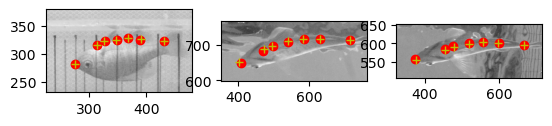

In [212]:
frpts = ptsall3d.loc[(idx[0], idx[1], slice(None))]

fig, ax = plt.subplots(ncols=len(cap), nrows=1) #, sharex=True, sharey=True)

for cam1, cap1, ax1 in zip(camnames, cap, ax):
    cap1.set(1, fr)
    ret, frame1 = cap1.read()

    ax1.imshow(frame1)

    x1 = frpts[(cam1, 'x')]
    y1 = frpts[(cam1, 'y')]
    xr1 = frpts[(cam1, 'Xr')]
    yr1 = frpts[(cam1, 'Yr')]

    ax1.plot(x1,y1, 'ro')
    ax1.plot(xr1,yr1, 'y+')

    xx = frpts.loc[(slice(None)), (cam1, ['x','Xr'])].stack()
    yy = frpts.loc[(slice(None)), (cam1, ['y','Yr'])].stack()

    ax1.set_xlim(pd.concat([xx.min(), xx.max()]).to_numpy() + np.array([-50, 50]))
    ax1.set_ylim(pd.concat([yy.min(), yy.max()]).to_numpy() + np.array([-50, 50]))

In [213]:
for cap1 in cap:
    cap1.release()